<a href="https://colab.research.google.com/github/Nikitha-2003/catsvsdogsclassification/blob/main/catsvsdogsclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import os
import cv2
# Directory containing the "Train" folder
directory = "/content/train"

filepath = []
label = []
corrupted_images = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path, img)
        try:
            # Attempt to read the image
            img_array = cv2.imread(img_path)

            # Check if the image array is not empty
            if img_array is not None and not img_array.size == 0:
                filepath.append(img_path)
                label.append(fold)
            else:
                corrupted_images.append(img_path)

        except Exception as e:
            # If an error occurs, treat it as a corrupted image
            corrupted_images.append(img_path)
            continue

# Concat data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

# Remove corrupted images from the data frame
for corrupted_img_path in corrupted_images:
    df_train = df_train[df_train['filepath'] != corrupted_img_path]

print("Number of corrupted images removed:", len(corrupted_images))
print("Remaining images in the dataset:", len(df_train))

Number of corrupted images removed: 0
Remaining images in the dataset: 20000


In [8]:
# Head
df_train.head()

filepath label
0   /content/train/dogs/dog.8965.jpg  dogs
1   /content/train/dogs/dog.3333.jpg  dogs
2    /content/train/dogs/dog.706.jpg  dogs
3  /content/train/dogs/dog.11469.jpg  dogs
4   /content/train/dogs/dog.1295.jpg  dogs

In [9]:
num_images = 12
class_animal = 'Cat'
directory_path = '/content/train/cats'
image_filenames = os.listdir(directory_path)

if len(image_filenames) < num_images:
    print(f"Only found images {len(image_filenames)} images in {directory_path}, displaying them all.")
    num_images = len(image_filenames)

selected_images = random.sample(image_filenames, num_images)

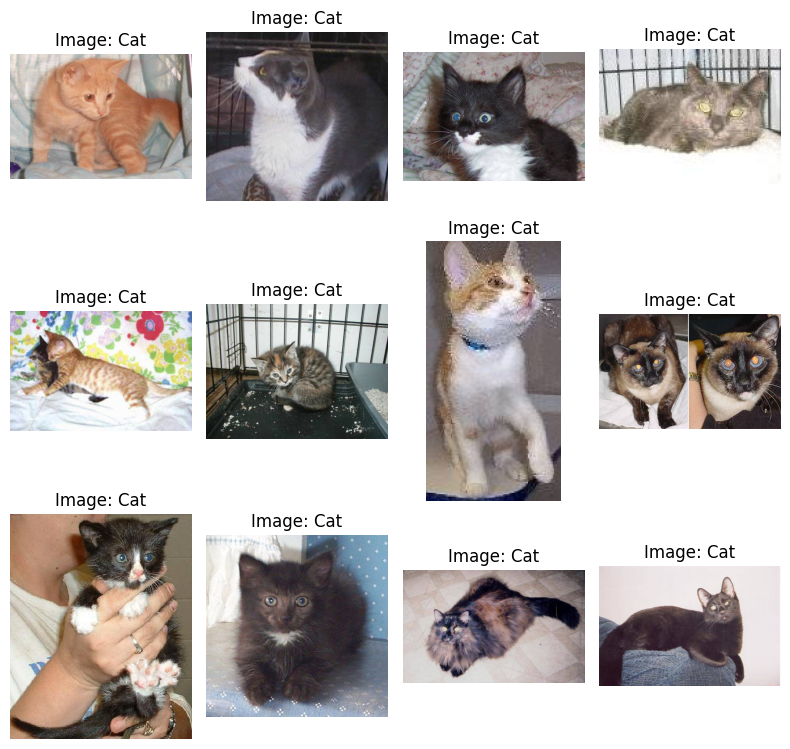

In [10]:
fig, axes = plt.subplots(3,4, figsize=(8, 8))
axes = axes.ravel()

for i, image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_file)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_animal}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
num_images = 12
class_animal = 'Dog'
directory_path = '/content/train/dogs'
image_filenames = os.listdir(directory_path)

In [12]:
if len(image_filenames) < num_images:
    print(f"Only found images {len(image_filenames)} images in {directory_path}, displaying them all.")
    num_images = len(image_filenames)

In [13]:
selected_images = random.sample(image_filenames, num_images)

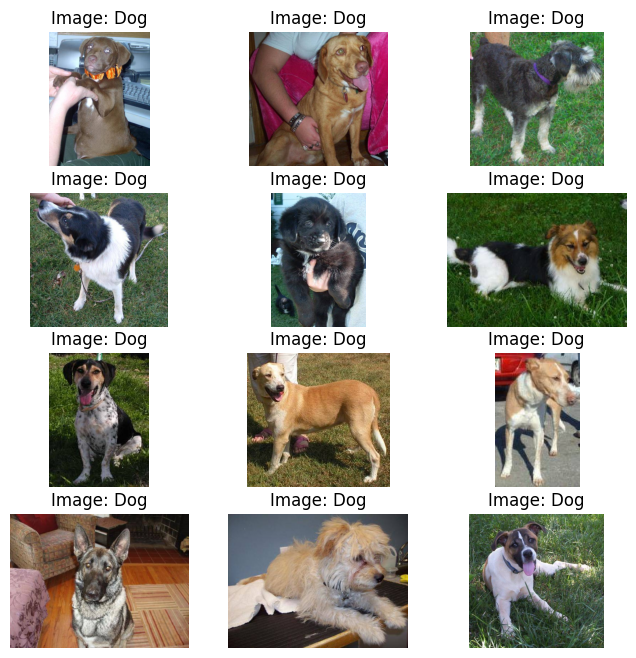

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(8, 8))
axes = axes.ravel()

for i, image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_file)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_animal}")
    axes[i].axis('off')

In [15]:
def plot_images_from_directory(directory_path, class_animal, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_animal}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

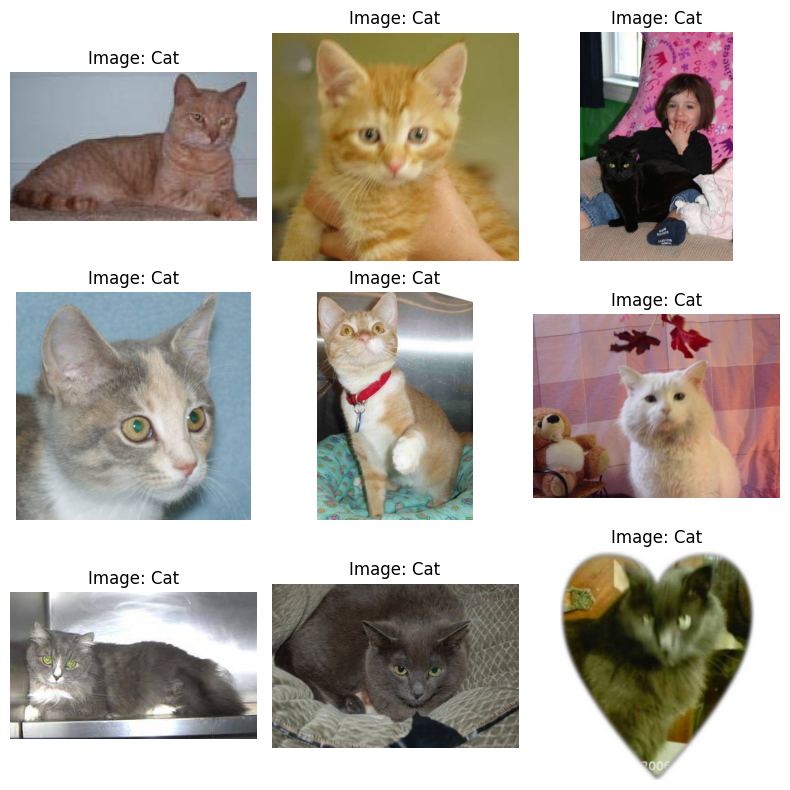

In [16]:
cat_directory_path = '/content/train/cats'
plot_images_from_directory(cat_directory_path, class_animal = 'Cat')

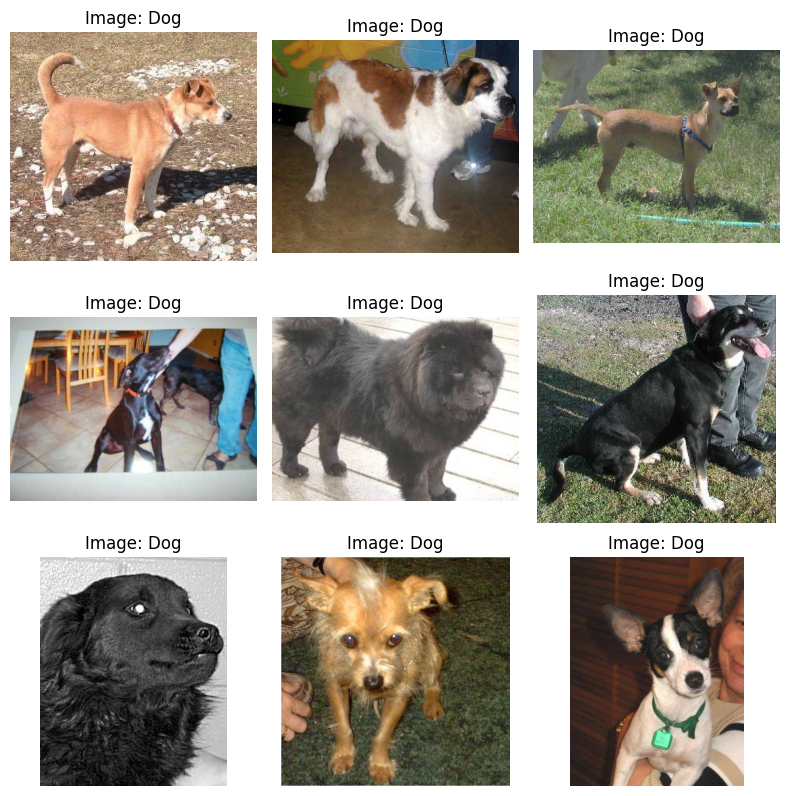

In [17]:
dog_directory_path = '/content/train/dogs'
plot_images_from_directory(dog_directory_path, class_animal = 'Dog')

In [18]:
cat_images = os.listdir(cat_directory_path)
dog_images = os.listdir(dog_directory_path)

classes_animals = ['Cats', 'Dogs']
count = [len(cat_images), len(dog_images)]

print(count)

[10000, 10000]


<ipython-input-19-f8231ac95a46>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


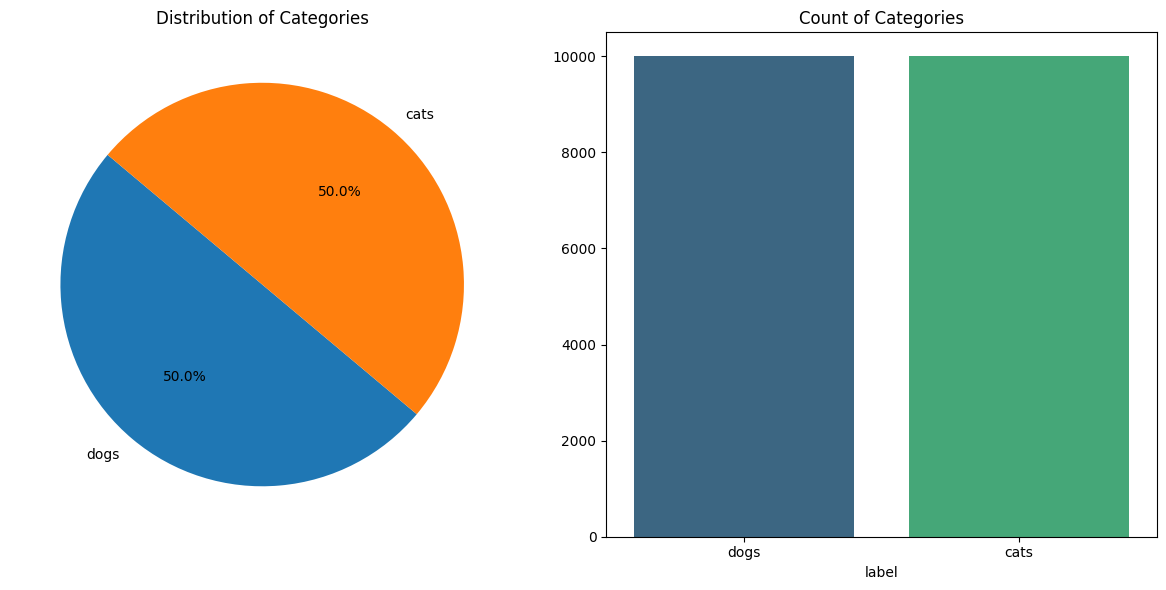

In [19]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
train_df, test_val_df = train_test_split(df_train, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Data generator for training
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

# Data generator for validation
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

# Data generator for test
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

Found 14000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


In [21]:
train_class_labels = train_generator.class_indices
print("training class labels: ", train_class_labels)

validation_class_labels = validation_generator.class_indices
print('validation class labels: ', validation_class_labels)

training class labels:  {'cats': 0, 'dogs': 1}
validation class labels:  {'cats': 0, 'dogs': 1}


In [22]:
def plot_images_from_generator(generator, num_images=4):
    images, labels = next(generator)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis(False)

    plt.tight_layout()
    plt.show()

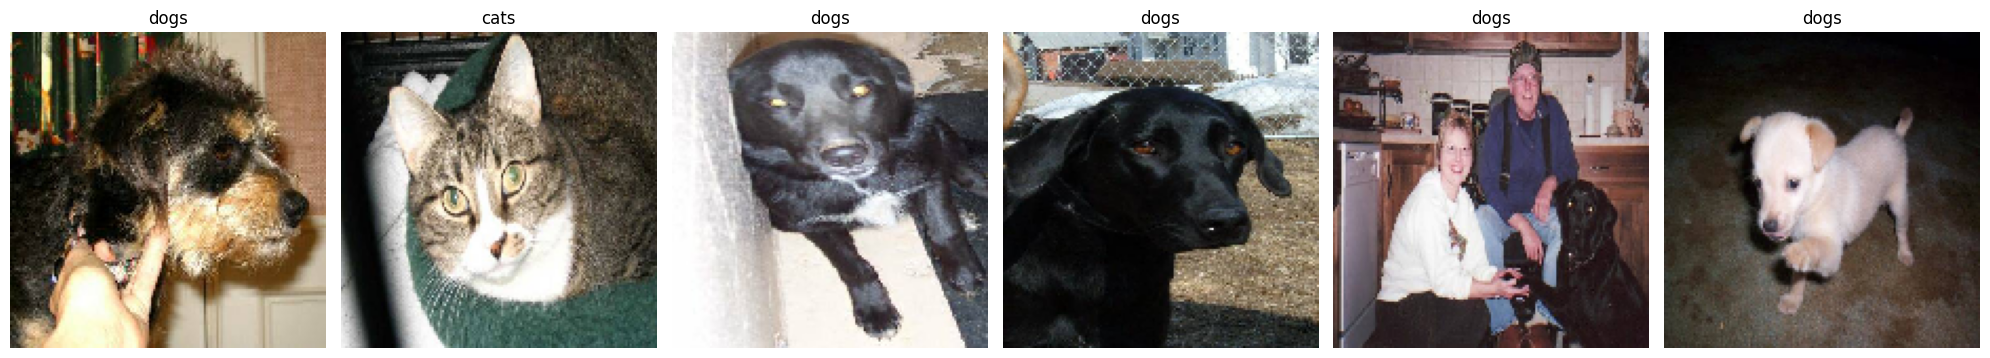

In [42]:
plot_images_from_generator(train_generator, num_images=6)

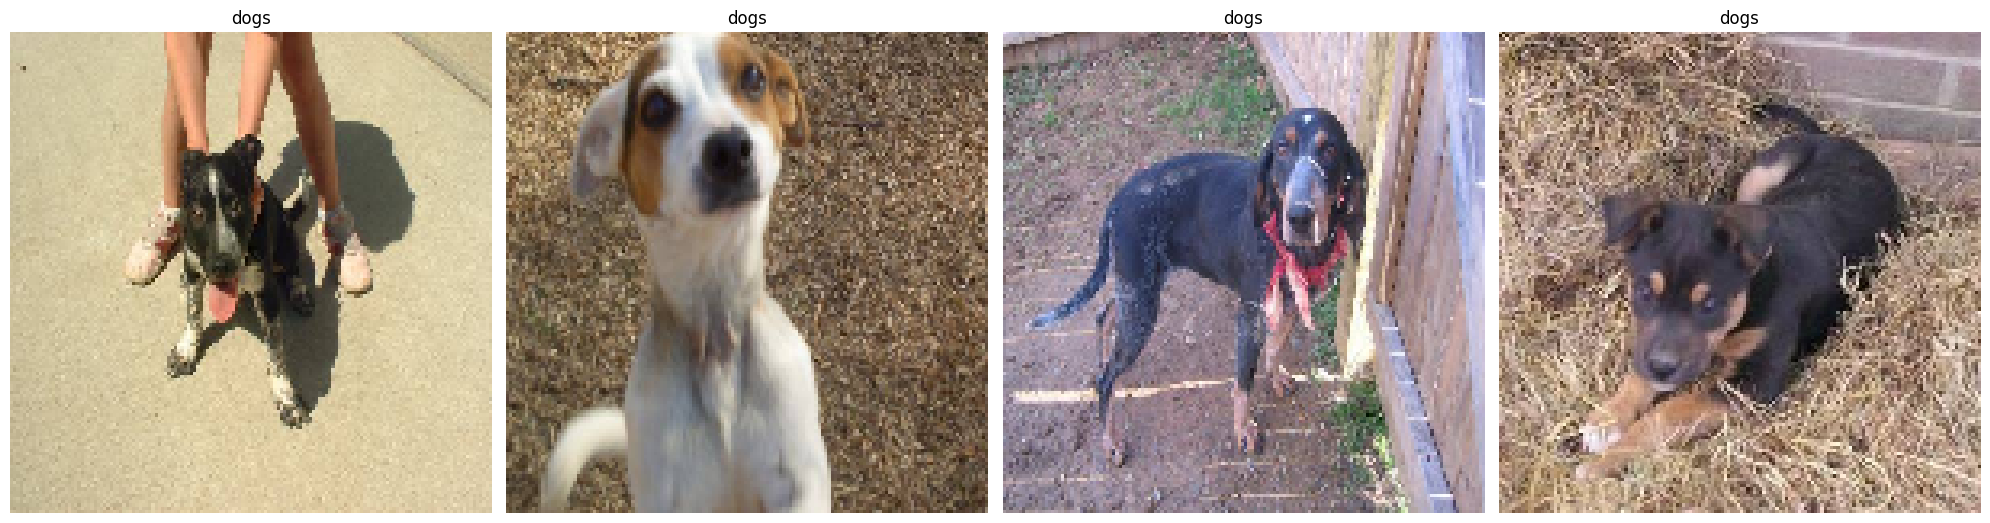

In [23]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [24]:
train_generator.reset()
train_generator.reset()

In [25]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

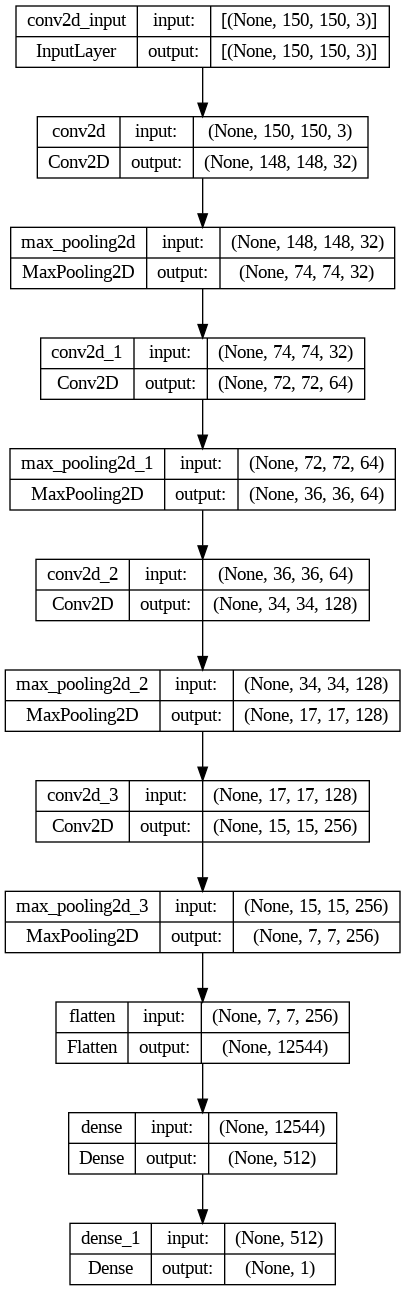

In [26]:
plot_model(model, to_file = 'Architecture.png', show_shapes=True, show_layer_names=True)

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
batch = 20
train_steps = np.ceil(train_generator.samples / batch)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch)
print(train_steps, validation_steps_per_epoch)

700.0 150.0


In [31]:
history = model.fit(train_generator,
                    steps_per_epoch=200,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=200)

Epoch 1/10
200/200 [==============================] - 208s 1s/step - loss: 0.6780 - accuracy: 0.5617
Epoch 2/10
200/200 [==============================] - 205s 1s/step - loss: 0.6619 - accuracy: 0.5910
Epoch 3/10
200/200 [==============================] - 202s 1s/step - loss: 0.6181 - accuracy: 0.6467
Epoch 4/10
200/200 [==============================] - 203s 1s/step - loss: 0.5830 - accuracy: 0.6848
Epoch 5/10
200/200 [==============================] - 206s 1s/step - loss: 0.5362 - accuracy: 0.7300
Epoch 6/10
200/200 [==============================] - 209s 1s/step - loss: 0.5072 - accuracy: 0.7517
Epoch 7/10
200/200 [==============================] - 207s 1s/step - loss: 0.4783 - accuracy: 0.7688
Epoch 8/10
200/200 [==============================] - 209s 1s/step - loss: 0.4292 - accuracy: 0.8037
Epoch 9/10
200/200 [==============================] - 209s 1s/step - loss: 0.4217 - accuracy: 0.8067
Epoch 10/10
200/200 [==============================] - 208s 1s/step - loss: 0.3995 - accura

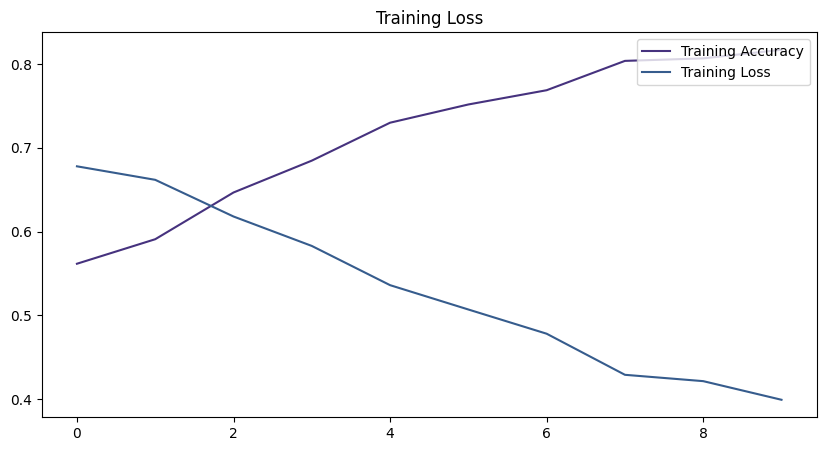

In [39]:
acc = history.history['accuracy']
# Check if 'val_accuracy' exists before accessing it
if 'val_accuracy' in history.history:
    val_acc = history.history['val_accuracy']
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='val_accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and val_accuracy')
else:
    val_acc = None  # or any default value you prefer
    print("Warning: No validation data was used during training. 'val_accuracy' is not available.")
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')

loss = history.history['loss']
# Similarly for val_loss
if 'val_loss' in history.history:
    val_loss = history.history['val_loss']
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='val_loss')
    plt.legend(loc='upper right')
    plt.title('Training val_loss')
else:
    val_loss = None
    print("Warning: No validation data was used during training. 'val_loss' is not available.")
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title('Training Loss')
plt.show()

In [40]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Test loss: {loss:.2f}")

150/150 [==============================] - 43s 287ms/step - loss: 0.4580 - accuracy: 0.7947
Test accuracy: 79.47%
Test loss: 0.46
